In [1]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay, auc, log_loss, recall_score, f1_score, precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Data Science/1. Telco Customer Churn/Data/TelcoChurn_prep.csv")

# Persiapan data

In [5]:
df = df.drop(["customerID"],axis=1)

In [6]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [7]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [8]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

In [9]:
selector = SelectKBest(score_func=f_classif, k=10)
X_train_res_sel = selector.fit_transform(X_train_res, y_train_res)
X_test_sel = selector.transform(X_test_sm)

In [10]:
selected_features = selector.get_feature_names_out(input_features=X.columns)

X_train_res_sel_df = pd.DataFrame(X_train_res_sel, columns=selected_features)
X_test_sel_df = pd.DataFrame(X_test_sel, columns=selected_features)

In [11]:
pca = PCA(n_components=5)
X_train_res_pca = pca.fit_transform(X_train_res_sel)
X_test_pca = pca.transform(X_test_sel)

In [12]:
X_train_res_pca_df = pd.DataFrame(X_train_res_pca, columns=[f'PC{i+1}' for i in range(X_train_res_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Baseline Model

In [23]:
dt = DecisionTreeClassifier(random_state=42)

In [24]:
dt.fit(X_train_res_pca_df, y_train_res)

DecisionTreeClassifier(random_state=42)

In [25]:
y_pred = dt.predict(X_test_pca_df)

In [26]:
print("Recall:", recall_score(y_test_sm, y_pred))
print("F1-score:", f1_score(y_test_sm, y_pred))
print("Confusion matriks: \n",confusion_matrix(y_test_sm, y_pred))
print(classification_report(y_test_sm, y_pred))

Recall: 0.6149732620320856
F1-score: 0.5291411042944786
Confusion matriks: 
 [[1151  398]
 [ 216  345]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1549
           1       0.46      0.61      0.53       561

    accuracy                           0.71      2110
   macro avg       0.65      0.68      0.66      2110
weighted avg       0.74      0.71      0.72      2110



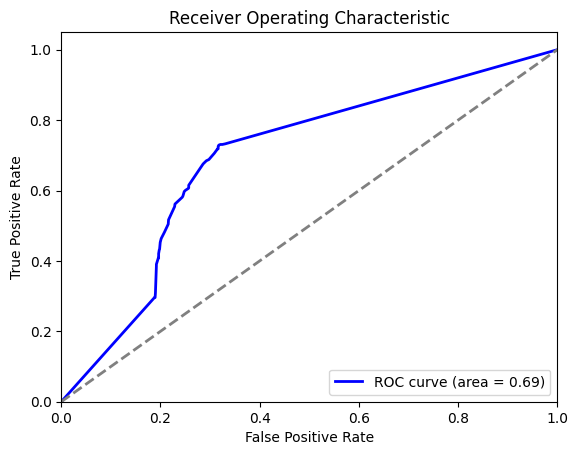

In [27]:
y_pred_proba = dt.predict_proba(X_test_pca_df)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_sm, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

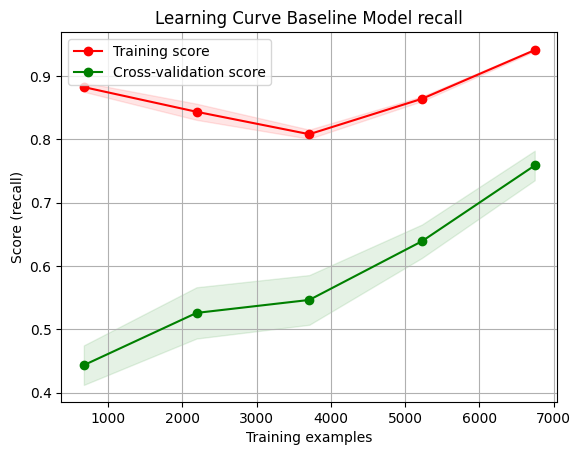

In [28]:
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(dt, X_train_res_pca_df, y_train_res, cv=cv, scoring='recall')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve Baseline Model recall")
plt.xlabel("Training examples")
plt.ylabel("Score (recall)")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Model Performance Curves

## Max Depth

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>1, train recall: 0.746, test recall: 0.750
>1, train f1: 0.744, test f1: 0.593
Recall Rentang adalah = -0.004
F1 Rentang adalah = 0.151




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>2, train recall: 0.760, test recall: 0.750
>2, train f1: 0.746, test f1: 0.593
Recall Rentang adalah = 0.010
F1 Rentang adalah = 0.154




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>3, train recall: 0.828, test recall: 0.831
>3, train f1: 0.772, test f1: 0.580
Recall Rentang adalah = -0.002
F1 Rentang adalah = 0.192




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>4, train recall: 0.819, test recall: 0.811
>4, train f1: 0.774, test f1: 0.575
Recall Rentang adalah = 0.008
F1 Rentang adalah = 0.199




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>5, train recall: 0.809, test recall: 0.820
>5, train f1: 0.776, test f1: 0.591
Recall Rentang adalah = -0.011
F1 Rentang adalah = 0.185




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>6, train recall: 0.814, test recall: 0.793
>6, train f1: 0.780, test f1: 0.585
Recall Rentang adalah = 0.021
F1 Rentang adalah = 0.195




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>7, train recall: 0.820, test recall: 0.804
>7, train f1: 0.782, test f1: 0.583
Recall Rentang adalah = 0.016
F1 Rentang adalah = 0.199




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>8, train recall: 0.813, test recall: 0.783
>8, train f1: 0.778, test f1: 0.588
Recall Rentang adalah = 0.030
F1 Rentang adalah = 0.190




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>9, train recall: 0.815, test recall: 0.731
>9, train f1: 0.781, test f1: 0.580
Recall Rentang adalah = 0.084
F1 Rentang adalah = 0.201




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>10, train recall: 0.813, test recall: 0.724
>10, train f1: 0.781, test f1: 0.580
Recall Rentang adalah = 0.089
F1 Rentang adalah = 0.201




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>11, train recall: 0.820, test recall: 0.695
>11, train f1: 0.785, test f1: 0.571
Recall Rentang adalah = 0.125
F1 Rentang adalah = 0.214




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>12, train recall: 0.805, test recall: 0.674
>12, train f1: 0.779, test f1: 0.559
Recall Rentang adalah = 0.131
F1 Rentang adalah = 0.220




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>13, train recall: 0.805, test recall: 0.681
>13, train f1: 0.778, test f1: 0.561
Recall Rentang adalah = 0.124
F1 Rentang adalah = 0.218




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>14, train recall: 0.804, test recall: 0.679
>14, train f1: 0.779, test f1: 0.553
Recall Rentang adalah = 0.124
F1 Rentang adalah = 0.226




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>15, train recall: 0.791, test recall: 0.668
>15, train f1: 0.772, test f1: 0.556
Recall Rentang adalah = 0.122
F1 Rentang adalah = 0.215




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>16, train recall: 0.785, test recall: 0.663
>16, train f1: 0.770, test f1: 0.547
Recall Rentang adalah = 0.122
F1 Rentang adalah = 0.224




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>17, train recall: 0.783, test recall: 0.661
>17, train f1: 0.770, test f1: 0.542
Recall Rentang adalah = 0.122
F1 Rentang adalah = 0.228




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>18, train recall: 0.782, test recall: 0.636
>18, train f1: 0.770, test f1: 0.536
Recall Rentang adalah = 0.146
F1 Rentang adalah = 0.233




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>19, train recall: 0.774, test recall: 0.638
>19, train f1: 0.766, test f1: 0.538
Recall Rentang adalah = 0.136
F1 Rentang adalah = 0.228




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>20, train recall: 0.772, test recall: 0.633
>20, train f1: 0.766, test f1: 0.538
Recall Rentang adalah = 0.139
F1 Rentang adalah = 0.228




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>21, train recall: 0.770, test recall: 0.633
>21, train f1: 0.764, test f1: 0.539
Recall Rentang adalah = 0.137
F1 Rentang adalah = 0.225




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>22, train recall: 0.768, test recall: 0.613
>22, train f1: 0.763, test f1: 0.528
Recall Rentang adalah = 0.154
F1 Rentang adalah = 0.236




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>23, train recall: 0.765, test recall: 0.613
>23, train f1: 0.763, test f1: 0.523
Recall Rentang adalah = 0.152
F1 Rentang adalah = 0.240




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>24, train recall: 0.765, test recall: 0.604
>24, train f1: 0.764, test f1: 0.521
Recall Rentang adalah = 0.161
F1 Rentang adalah = 0.243




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>25, train recall: 0.766, test recall: 0.613
>25, train f1: 0.764, test f1: 0.524
Recall Rentang adalah = 0.153
F1 Rentang adalah = 0.239




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>26, train recall: 0.764, test recall: 0.619
>26, train f1: 0.762, test f1: 0.528
Recall Rentang adalah = 0.145
F1 Rentang adalah = 0.234




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>27, train recall: 0.763, test recall: 0.613
>27, train f1: 0.761, test f1: 0.527
Recall Rentang adalah = 0.150
F1 Rentang adalah = 0.234




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>28, train recall: 0.762, test recall: 0.610
>28, train f1: 0.761, test f1: 0.525
Recall Rentang adalah = 0.152
F1 Rentang adalah = 0.235




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>29, train recall: 0.761, test recall: 0.611
>29, train f1: 0.760, test f1: 0.525
Recall Rentang adalah = 0.149
F1 Rentang adalah = 0.235




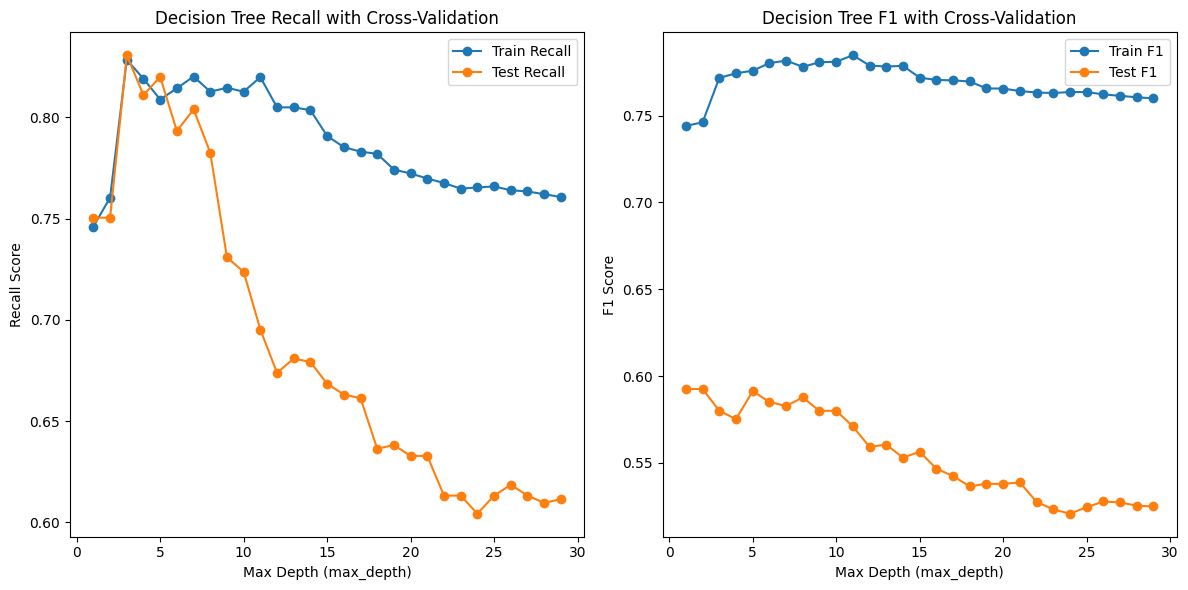

In [29]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for i in values:
    model = DecisionTreeClassifier(max_depth=i, random_state=42)

    train_recalls_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca_df, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Max Depth (max_depth)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("Decision Tree Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Max Depth (max_depth)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Decision Tree F1 with Cross-Validation")

plt.tight_layout()
plt.show()

- Model mulai overfitting pada data pelatihan ketika max_depth meningkat. Hal ini ditunjukkan oleh penurunan signifikan dalam recall dan F1 score pada data pengujian

- Max_depth sekitar 3 hingga 8 tampaknya memberikan keseimbangan terbaik antara kinerja pelatihan dan pengujian sebelum model mulai overfitting.

## min_samples_split

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>2, train recall: 0.759, test recall: 0.615
>2, train f1: 0.760, test f1: 0.529
Recall Rentang adalah = 0.144
F1 Rentang adalah = 0.230




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>3, train recall: 0.753, test recall: 0.611
>3, train f1: 0.758, test f1: 0.534
Recall Rentang adalah = 0.141
F1 Rentang adalah = 0.224




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>4, train recall: 0.759, test recall: 0.631
>4, train f1: 0.760, test f1: 0.542
Recall Rentang adalah = 0.128
F1 Rentang adalah = 0.218




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>5, train recall: 0.752, test recall: 0.633
>5, train f1: 0.756, test f1: 0.539
Recall Rentang adalah = 0.119
F1 Rentang adalah = 0.217




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>6, train recall: 0.763, test recall: 0.643
>6, train f1: 0.763, test f1: 0.545
Recall Rentang adalah = 0.120
F1 Rentang adalah = 0.218




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>7, train recall: 0.758, test recall: 0.649
>7, train f1: 0.759, test f1: 0.547
Recall Rentang adalah = 0.109
F1 Rentang adalah = 0.212




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>8, train recall: 0.765, test recall: 0.649
>8, train f1: 0.762, test f1: 0.544
Recall Rentang adalah = 0.117
F1 Rentang adalah = 0.219




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>9, train recall: 0.764, test recall: 0.649
>9, train f1: 0.763, test f1: 0.543
Recall Rentang adalah = 0.115
F1 Rentang adalah = 0.219




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>10, train recall: 0.765, test recall: 0.635
>10, train f1: 0.763, test f1: 0.535
Recall Rentang adalah = 0.131
F1 Rentang adalah = 0.227




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>11, train recall: 0.767, test recall: 0.631
>11, train f1: 0.764, test f1: 0.534
Recall Rentang adalah = 0.136
F1 Rentang adalah = 0.230




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>12, train recall: 0.767, test recall: 0.640
>12, train f1: 0.764, test f1: 0.537
Recall Rentang adalah = 0.127
F1 Rentang adalah = 0.228




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>13, train recall: 0.768, test recall: 0.645
>13, train f1: 0.766, test f1: 0.539
Recall Rentang adalah = 0.123
F1 Rentang adalah = 0.226




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>14, train recall: 0.768, test recall: 0.643
>14, train f1: 0.764, test f1: 0.539
Recall Rentang adalah = 0.124
F1 Rentang adalah = 0.225




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>15, train recall: 0.770, test recall: 0.645
>15, train f1: 0.765, test f1: 0.539
Recall Rentang adalah = 0.125
F1 Rentang adalah = 0.226




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>16, train recall: 0.775, test recall: 0.651
>16, train f1: 0.767, test f1: 0.543
Recall Rentang adalah = 0.124
F1 Rentang adalah = 0.224




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>17, train recall: 0.772, test recall: 0.654
>17, train f1: 0.765, test f1: 0.543
Recall Rentang adalah = 0.118
F1 Rentang adalah = 0.222




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>18, train recall: 0.775, test recall: 0.638
>18, train f1: 0.767, test f1: 0.536
Recall Rentang adalah = 0.137
F1 Rentang adalah = 0.231




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>19, train recall: 0.776, test recall: 0.640
>19, train f1: 0.767, test f1: 0.537
Recall Rentang adalah = 0.136
F1 Rentang adalah = 0.231




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>20, train recall: 0.777, test recall: 0.645
>20, train f1: 0.767, test f1: 0.544
Recall Rentang adalah = 0.131
F1 Rentang adalah = 0.223




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>21, train recall: 0.781, test recall: 0.649
>21, train f1: 0.769, test f1: 0.547
Recall Rentang adalah = 0.133
F1 Rentang adalah = 0.222




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>22, train recall: 0.780, test recall: 0.654
>22, train f1: 0.769, test f1: 0.549
Recall Rentang adalah = 0.126
F1 Rentang adalah = 0.220




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>23, train recall: 0.782, test recall: 0.663
>23, train f1: 0.771, test f1: 0.554
Recall Rentang adalah = 0.119
F1 Rentang adalah = 0.218




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>24, train recall: 0.784, test recall: 0.665
>24, train f1: 0.772, test f1: 0.555
Recall Rentang adalah = 0.120
F1 Rentang adalah = 0.217




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>25, train recall: 0.784, test recall: 0.661
>25, train f1: 0.771, test f1: 0.555
Recall Rentang adalah = 0.123
F1 Rentang adalah = 0.216




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>26, train recall: 0.784, test recall: 0.667
>26, train f1: 0.771, test f1: 0.556
Recall Rentang adalah = 0.118
F1 Rentang adalah = 0.215




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>27, train recall: 0.787, test recall: 0.672
>27, train f1: 0.773, test f1: 0.557
Recall Rentang adalah = 0.115
F1 Rentang adalah = 0.216




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>28, train recall: 0.788, test recall: 0.679
>28, train f1: 0.771, test f1: 0.560
Recall Rentang adalah = 0.109
F1 Rentang adalah = 0.211




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>29, train recall: 0.786, test recall: 0.683
>29, train f1: 0.771, test f1: 0.562
Recall Rentang adalah = 0.103
F1 Rentang adalah = 0.209




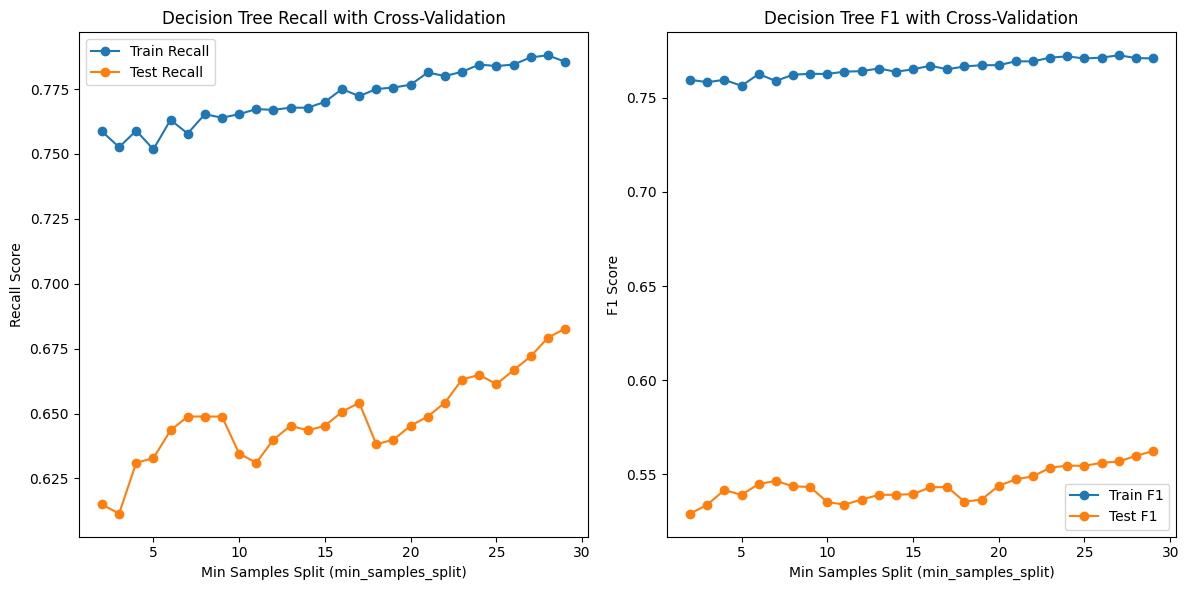

In [30]:
values = [i for i in range(2, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for i in values:
    model = DecisionTreeClassifier(min_samples_split=i, random_state=42)

    train_recalls_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca_df, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Min Samples Split (min_samples_split)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("Decision Tree Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Min Samples Split (min_samples_split)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Decision Tree F1 with Cross-Validation")

plt.tight_layout()
plt.show()

- Model menunjukkan tanda-tanda overfitting pada nilai min_samples_split yang kecil, seperti yang ditunjukkan oleh perbedaan yang signifikan antara training score dan test score. Peningkatan nilai min_samples_split membantu mengurangi overfitting.

- Berdasarkan grafik, nilai min_samples_split sekitar 15 hingga 25 tampaknya memberikan keseimbangan terbaik antara kinerja pelatihan dan pengujian sebelum model mulai menunjukkan peningkatan performa yang signifikan pada data pengujian.

## min_samples_leaf

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>1, train recall: 0.759, test recall: 0.615
>1, train f1: 0.760, test f1: 0.529
Recall Rentang adalah = 0.144
F1 Rentang adalah = 0.230




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>2, train recall: 0.741, test recall: 0.615
>2, train f1: 0.754, test f1: 0.531
Recall Rentang adalah = 0.126
F1 Rentang adalah = 0.223




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>3, train recall: 0.769, test recall: 0.649
>3, train f1: 0.764, test f1: 0.552
Recall Rentang adalah = 0.120
F1 Rentang adalah = 0.212




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>4, train recall: 0.757, test recall: 0.636
>4, train f1: 0.760, test f1: 0.553
Recall Rentang adalah = 0.121
F1 Rentang adalah = 0.207




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>5, train recall: 0.772, test recall: 0.663
>5, train f1: 0.764, test f1: 0.554
Recall Rentang adalah = 0.109
F1 Rentang adalah = 0.210




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>6, train recall: 0.766, test recall: 0.656
>6, train f1: 0.762, test f1: 0.555
Recall Rentang adalah = 0.110
F1 Rentang adalah = 0.206




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>7, train recall: 0.789, test recall: 0.674
>7, train f1: 0.772, test f1: 0.557
Recall Rentang adalah = 0.116
F1 Rentang adalah = 0.215




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>8, train recall: 0.784, test recall: 0.665
>8, train f1: 0.770, test f1: 0.551
Recall Rentang adalah = 0.119
F1 Rentang adalah = 0.219




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>9, train recall: 0.803, test recall: 0.708
>9, train f1: 0.779, test f1: 0.576
Recall Rentang adalah = 0.095
F1 Rentang adalah = 0.203




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>10, train recall: 0.789, test recall: 0.693
>10, train f1: 0.772, test f1: 0.566
Recall Rentang adalah = 0.095
F1 Rentang adalah = 0.206




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>11, train recall: 0.794, test recall: 0.706
>11, train f1: 0.774, test f1: 0.573
Recall Rentang adalah = 0.088
F1 Rentang adalah = 0.201




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>12, train recall: 0.793, test recall: 0.704
>12, train f1: 0.773, test f1: 0.578
Recall Rentang adalah = 0.089
F1 Rentang adalah = 0.195




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>13, train recall: 0.800, test recall: 0.708
>13, train f1: 0.778, test f1: 0.577
Recall Rentang adalah = 0.093
F1 Rentang adalah = 0.201




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>14, train recall: 0.799, test recall: 0.717
>14, train f1: 0.776, test f1: 0.582
Recall Rentang adalah = 0.083
F1 Rentang adalah = 0.194




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>15, train recall: 0.802, test recall: 0.727
>15, train f1: 0.778, test f1: 0.593
Recall Rentang adalah = 0.075
F1 Rentang adalah = 0.184




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>16, train recall: 0.796, test recall: 0.729
>16, train f1: 0.775, test f1: 0.584
Recall Rentang adalah = 0.067
F1 Rentang adalah = 0.191




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>17, train recall: 0.799, test recall: 0.724
>17, train f1: 0.776, test f1: 0.583
Recall Rentang adalah = 0.075
F1 Rentang adalah = 0.193




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>18, train recall: 0.797, test recall: 0.733
>18, train f1: 0.776, test f1: 0.583
Recall Rentang adalah = 0.065
F1 Rentang adalah = 0.193




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>19, train recall: 0.802, test recall: 0.727
>19, train f1: 0.778, test f1: 0.579
Recall Rentang adalah = 0.075
F1 Rentang adalah = 0.199




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>20, train recall: 0.799, test recall: 0.733
>20, train f1: 0.777, test f1: 0.579
Recall Rentang adalah = 0.066
F1 Rentang adalah = 0.198




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>21, train recall: 0.804, test recall: 0.731
>21, train f1: 0.778, test f1: 0.579
Recall Rentang adalah = 0.073
F1 Rentang adalah = 0.199




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>22, train recall: 0.796, test recall: 0.731
>22, train f1: 0.774, test f1: 0.585
Recall Rentang adalah = 0.065
F1 Rentang adalah = 0.189




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>23, train recall: 0.801, test recall: 0.740
>23, train f1: 0.776, test f1: 0.582
Recall Rentang adalah = 0.062
F1 Rentang adalah = 0.194




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>24, train recall: 0.802, test recall: 0.742
>24, train f1: 0.776, test f1: 0.579
Recall Rentang adalah = 0.061
F1 Rentang adalah = 0.196




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>25, train recall: 0.808, test recall: 0.727
>25, train f1: 0.778, test f1: 0.583
Recall Rentang adalah = 0.081
F1 Rentang adalah = 0.196




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>26, train recall: 0.807, test recall: 0.724
>26, train f1: 0.780, test f1: 0.580
Recall Rentang adalah = 0.084
F1 Rentang adalah = 0.200




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>27, train recall: 0.807, test recall: 0.738
>27, train f1: 0.780, test f1: 0.583
Recall Rentang adalah = 0.069
F1 Rentang adalah = 0.197




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>28, train recall: 0.806, test recall: 0.722
>28, train f1: 0.779, test f1: 0.581
Recall Rentang adalah = 0.084
F1 Rentang adalah = 0.198




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


>29, train recall: 0.803, test recall: 0.718
>29, train f1: 0.777, test f1: 0.578
Recall Rentang adalah = 0.084
F1 Rentang adalah = 0.199




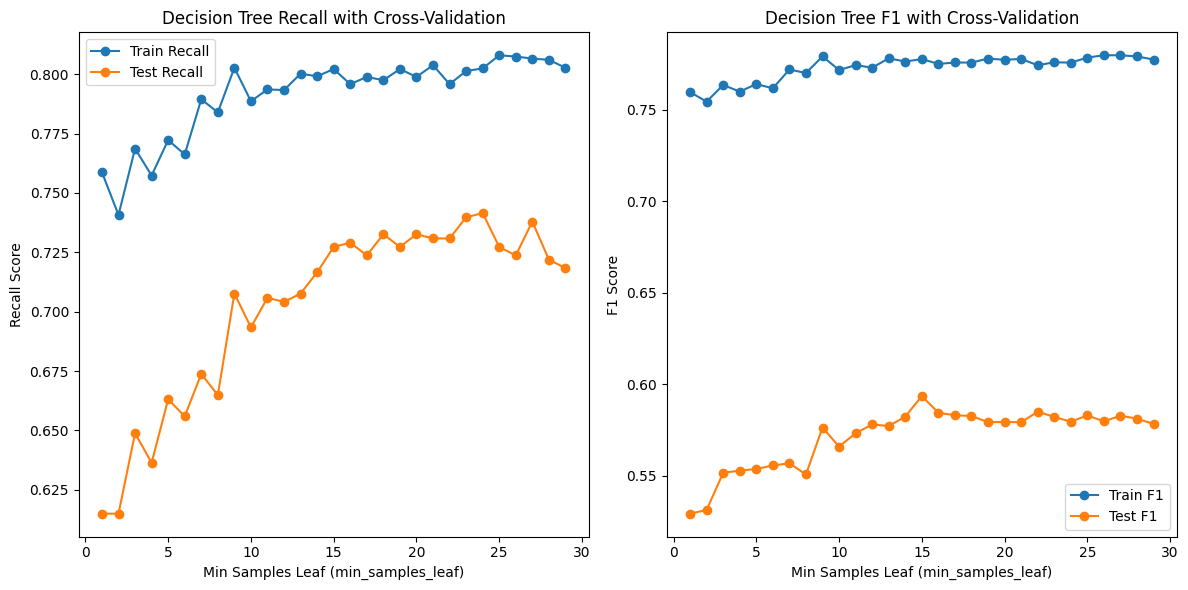

In [31]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for i in values:
    model = DecisionTreeClassifier(min_samples_leaf=i, random_state=42)

    train_recalls_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca_df, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Min Samples Leaf (min_samples_leaf)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("Decision Tree Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Min Samples Leaf (min_samples_leaf)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Decision Tree F1 with Cross-Validation")

plt.tight_layout()
plt.show()

- Model menunjukkan tanda-tanda overfitting pada nilai min_samples_leaf yang kecil, seperti yang ditunjukkan oleh perbedaan yang signifikan antara training score dan test score. Peningkatan nilai min_samples_leaf membantu mengurangi overfitting.

- Berdasarkan grafik, nilai min_samples_leaf sekitar 10 hingga 20 tampaknya memberikan keseimbangan terbaik antara kinerja pelatihan dan pengujian sebelum model mulai menunjukkan peningkatan performa yang signifikan pada data pengujian.

# Hyperparameter Tunning

In [32]:
param_grid = {
    'max_depth': range(3, 9),
    'min_samples_split': range(15, 26),
    'min_samples_leaf': range(10, 21)
}

In [33]:
dt = DecisionTreeClassifier(random_state=42)

In [34]:
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, scoring='recall')

In [35]:
grid_search.fit(X_train_res_pca_df, y_train_res)

GridSearchCV(cv=StratifiedKFold(n_splits=15, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(3, 9),
                         'min_samples_leaf': range(10, 21),
                         'min_samples_split': range(15, 26)},
             scoring='recall')

In [36]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 15}


In [37]:
best_model = grid_search.best_estimator_

# Evaluasi final model

In [38]:
dt = DecisionTreeClassifier(random_state=42, max_depth= 3, min_samples_leaf= 10, min_samples_split= 15)

In [39]:
dt.fit(X_train_res_pca_df, y_train_res)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=15,
                       random_state=42)

In [40]:
y_pred = dt.predict(X_test_pca_df)

In [41]:
print("Recall:", recall_score(y_test_sm, y_pred))
print("F1-score:", f1_score(y_test_sm, y_pred))
print("Confusion matriks: \n",confusion_matrix(y_test_sm, y_pred))
print(classification_report(y_test_sm, y_pred))

Recall: 0.8306595365418895
F1-score: 0.5799626633478532
Confusion matriks: 
 [[969 580]
 [ 95 466]]
              precision    recall  f1-score   support

           0       0.91      0.63      0.74      1549
           1       0.45      0.83      0.58       561

    accuracy                           0.68      2110
   macro avg       0.68      0.73      0.66      2110
weighted avg       0.79      0.68      0.70      2110



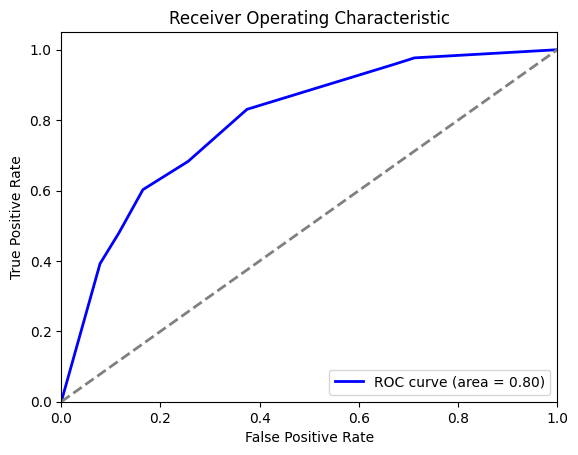

In [42]:
y_pred_proba = dt.predict_proba(X_test_pca_df)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_sm, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

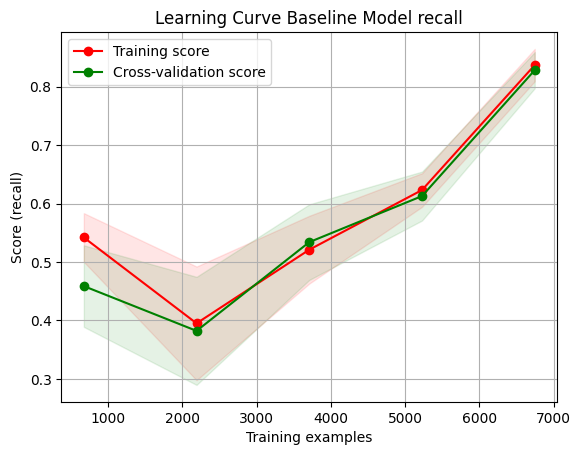

In [43]:
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(dt, X_train_res_pca_df, y_train_res, cv=cv, scoring='recall')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve Baseline Model recall")
plt.xlabel("Training examples")
plt.ylabel("Score (recall)")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

- Kedua skor ini mencapai sekitar 0.8, yang menunjukkan bahwa model memiliki kemampuan yang baik untuk memprediksi dengan benar.

- Gap antara training score dan cross-validation score mengecil seiring dengan peningkatan data pelatihan, menunjukkan perbaikan dalam kemampuan generalisasi model.

- Kedua skor menunjukkan stabilitas pada jumlah data pelatihan yang lebih besar, yang menunjukkan bahwa model tidak lagi mengalami overfitting atau underfitting yang signifikan.

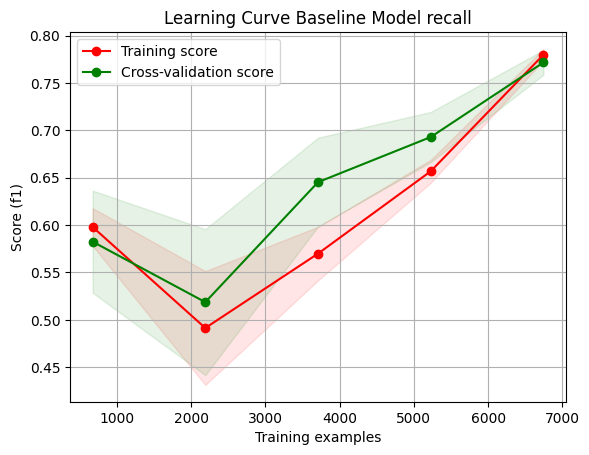

In [44]:
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(dt, X_train_res_pca_df, y_train_res, cv=cv, scoring='f1')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve Baseline Model recall")
plt.xlabel("Training examples")
plt.ylabel("Score (f1)")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

- Pada akhir kurva, model tidak menunjukkan tanda-tanda overfitting atau underfitting yang signifikan, dengan kedua skor yang tinggi dan seimbang.

# Threshold Adjustment Final Model

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

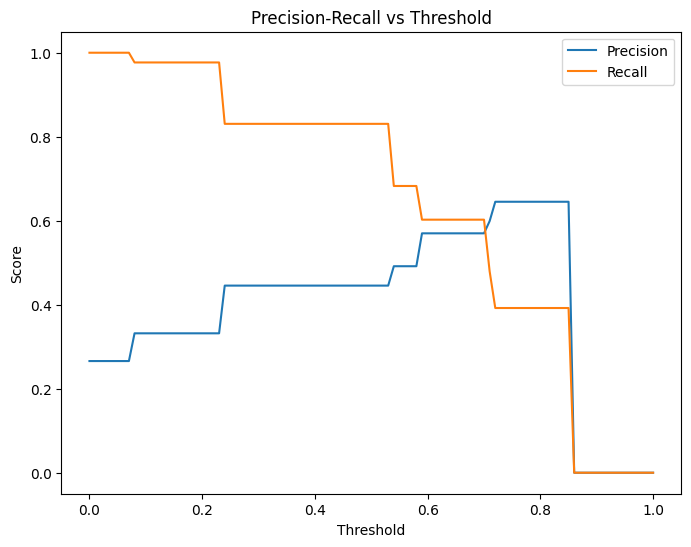

In [47]:
y_pred_proba = dt.predict_proba(X_test_pca_df)[:, 1]

precisions = []
recalls = []
thresholds = []

for threshold in np.arange(0, 1.01, 0.01):
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_test_sm, y_pred)
    recall = recall_score(y_test_sm, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    thresholds.append(threshold)

df_threshold = pd.DataFrame({'Threshold': thresholds, 'Precision': precisions, 'Recall': recalls})

plt.figure(figsize=(8, 6))
plt.plot(df_threshold['Threshold'], df_threshold['Precision'], label='Precision')
plt.plot(df_threshold['Threshold'], df_threshold['Recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

- Pada threshold rendah (dekat 0), recall tinggi (mendekati 1), tetapi precision rendah, Seiring dengan peningkatan threshold, precision meningkat, tetapi recall menurun.

- Grafik menunjukkan bahwa ada trade-off yang jelas antara precision dan recall. Ketika threshold meningkat, precision meningkat tetapi recall menurun, dan sebaliknya.

kita ingin sebanyak mungkin mengidentifikasin pelanggan churn,tapi bukan berarti kita tidak mempertimbangkan sama sekali False positives (mengira pelanggan akan churn padahal tidak), oleh karena itu kita akan mengimplementasikan threshold 0.4 pada final model

# Implementasi Threshold

In [48]:
optimal_threshold = 0.4

y_pred_new = (y_pred_proba >= optimal_threshold).astype(int)

print("Recall:", recall_score(y_test_sm, y_pred_new))
print("Precision:", precision_score(y_test_sm, y_pred_new))
print("Accuracy:", accuracy_score(y_test_sm, y_pred_new))
print("F1-score:", f1_score(y_test_sm, y_pred_new))
print("Confusion Matrix:\n", confusion_matrix(y_test_sm, y_pred_new))
print(classification_report(y_test_sm, y_pred_new))

Recall: 0.8306595365418895
Precision: 0.44550669216061184
Accuracy: 0.6800947867298578
F1-score: 0.5799626633478532
Confusion Matrix:
 [[969 580]
 [ 95 466]]
              precision    recall  f1-score   support

           0       0.91      0.63      0.74      1549
           1       0.45      0.83      0.58       561

    accuracy                           0.68      2110
   macro avg       0.68      0.73      0.66      2110
weighted avg       0.79      0.68      0.70      2110



ternyata thresthold 0.4 sama saja dengan model final dari segi scorr matriks evaluasi, oleh karena itu, kita coba thresthold 0.6

In [51]:
optimal_threshold = 0.6

y_pred_new = (y_pred_proba >= optimal_threshold).astype(int)

print("Recall:", recall_score(y_test_sm, y_pred_new))
print("Precision:", precision_score(y_test_sm, y_pred_new))
print("Accuracy:", accuracy_score(y_test_sm, y_pred_new))
print("F1-score:", f1_score(y_test_sm, y_pred_new))
print("Confusion Matrix:\n", confusion_matrix(y_test_sm, y_pred_new))
print(classification_report(y_test_sm, y_pred_new))

Recall: 0.6024955436720143
Precision: 0.5699831365935919
Accuracy: 0.7734597156398104
F1-score: 0.58578856152513
Confusion Matrix:
 [[1294  255]
 [ 223  338]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1549
           1       0.57      0.60      0.59       561

    accuracy                           0.77      2110
   macro avg       0.71      0.72      0.71      2110
weighted avg       0.78      0.77      0.78      2110



thresthold 0.6 punya skorr recall terlalu rendah, maka kita akan tetap menggunakan model final tanpa adannya penerapan thresthold meskipun false negatif dari final model tergolong besar